In [2]:
import numpy as np
import numba
import librosa
import librosa.display
%matplotlib nbagg
import mir_eval.sonify
from IPython.display import Audio
import matplotlib.pyplot as plt

In [3]:
y, sr = librosa.load('/Users/tom/Desktop/eh_BN1-129-Eb_c_hex_cln_03.wav')

In [4]:
Audio(data=y, rate=sr)

In [5]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)

<IPython.core.display.Javascript object>


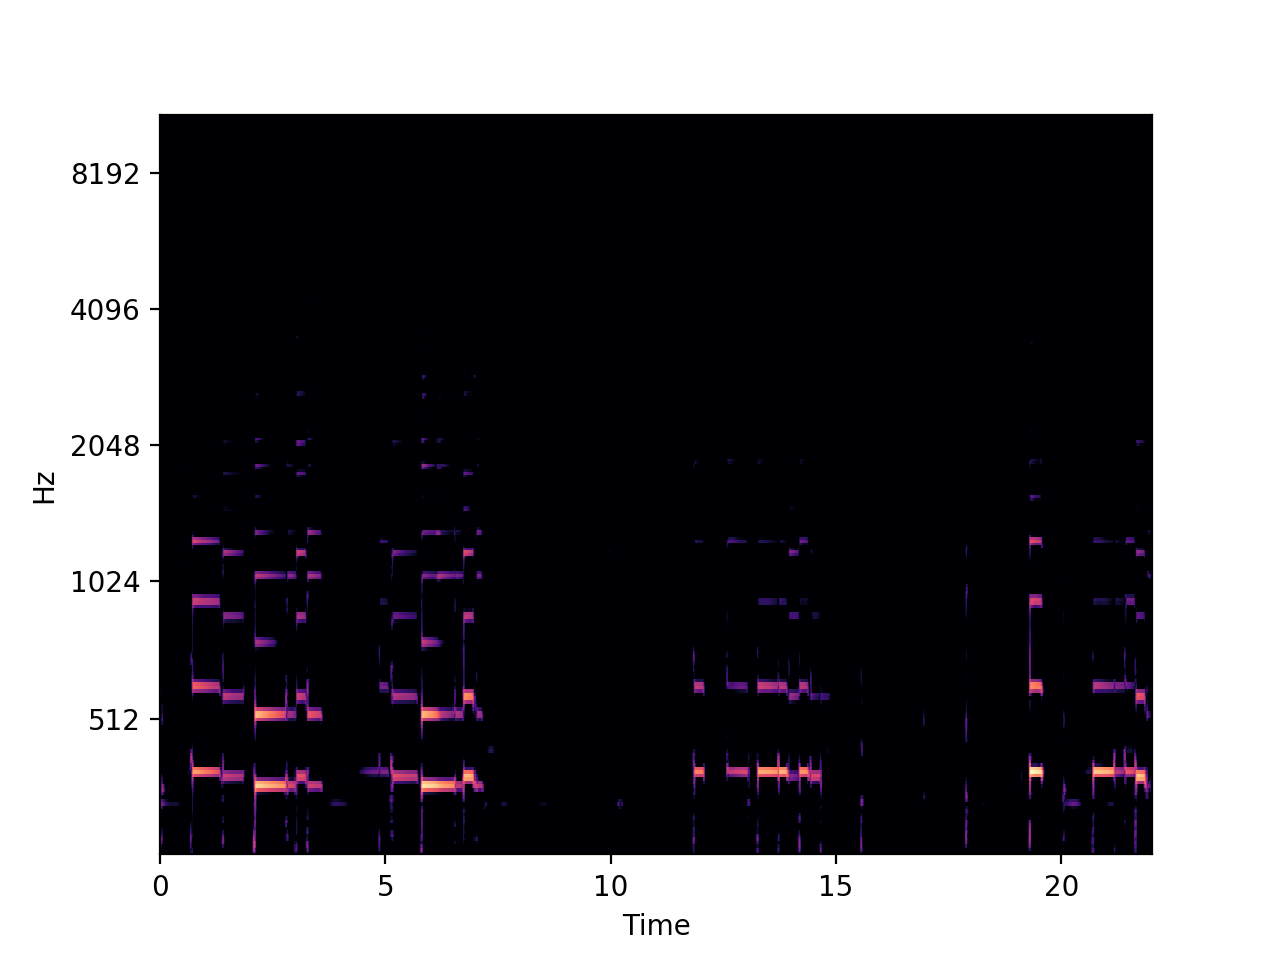

In [83]:
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='mel', x_axis='time', sr=sr)

In [69]:
@numba.jit(nopython=True)
def _viterbi(logp, logA, V, ptr, S):
    T, m = logp.shape
    
    V[0] = logp[0]
    
    for t in range(1, T):
        # Want V[t, j] <- p[t, j] * max_k V[t-1, k] * A[k, j]
        #    assume at time t-1 we were in state k
        #    transition k -> j

        # Broadcast over rows:
        #    Tout[k, j] = V[t-1, k] * A[k, j]
        #    then take the max over columns
        # 
        # We'll do this in log-space for stability

        Tout = V[t-1] + logA.T

        # Unroll the max/argmax loop to enable numba support
        for j in range(m):
            ptr[t, j] = np.argmax(Tout[j])
            V[t, j] = logp[t, j] + np.max(Tout[j])
            
    # Now roll backward
    
    # Get the last state
    S[-1] = np.argmax(V[-1])
    
    for t in range(T-2, -1, -1):
        S[t] = ptr[t+1, S[t+1]]
        
    return S, V, ptr


def viterbi(p, A):
    '''Viterbi decoding for discriminative HMMs
    
    Parameters
    ----------
    p : np.ndarray [shape=(T, m)], non-negative
        p[t] is the distribution over states at time t.
        Each row must sum to 1.
        
    A : np.ndarray [shape=(m, m)], non-negative
        A[i,j] is the probability of a transition from i->j.
        Each row must sum to 1.
        
    Returns
    -------
    s : np.ndarray [shape=(T,)]
        The most likely state sequence
    '''
    
    T, m = p.shape
    
    assert A.shape == (m, m)
    
    assert np.all(A >= 0)
    assert np.all(p >= 0)
    assert np.allclose(A.sum(axis=1), 1)
    assert np.allclose(p.sum(axis=1), 1)
    
    V = np.zeros((T, m), dtype=float)
    
    ptr = np.zeros((T, m), dtype=int)
    
    logA = np.log(A + 1e-10)
    logp = np.log(p + 1e-10)
    S = np.zeros(T, dtype=int)
    
    return _viterbi(logp, logA, V, ptr, S)

In [7]:
def make_self_transition(N, alpha=0.05):
    
    T = np.empty((N, N), dtype=float)
    T[:] = alpha / (N - 1)
    
    np.fill_diagonal(T, 1-alpha)
    
    return T

In [8]:
import scipy.signal

In [9]:
def make_bump_transition(N, window='hann', width=5, alpha=0.05):
    
    T = np.eye(N, dtype=float)
    w = librosa.filters.get_window(window, width, fftbins=False)[np.newaxis]
    T = scipy.signal.convolve(T, w, mode='same',)
    
    T = (1 - alpha) * T + alpha
    return T / T.sum(axis=1, keepdims=True)

In [10]:
@numba.jit
def ac_to_lagdelta(A, hop_length=512):
    
    m, n = A.shape
    
    Apad = np.pad(A, [(0, 0), (0, m)], mode='edge')
    
    D = -2 * Apad + Apad[0, :]
    
    # Instead of dividing by hop length, use linear interpolation
    for t in range(m):
        D[t, :-t] += Apad[0, t//hop_length:]
        
    return D[:, :n]

In [11]:
@numba.jit
def ac_to_lagcos(A, hop_length=512):
    
    m, n = A.shape
    
    Apad = np.pad(A, [(0, 0), (0, m)], mode='edge')
    
    Asqrt = np.sqrt(Apad[0])
    
    C = Apad / Asqrt
    
    for t in range(m):
        C[t, :-t] /= Asqrt[t//hop_length:]
        
    return C[:, :n]

In [12]:
@numba.jit
def yindist(y, hop_length=512, frame_length=2048):
    
    n_frames = 1 + int((len(y) - frame_length) / hop_length)
    D = np.zeros((frame_length, n_frames))
    
    for frame in range(n_frames):
        for t in range(frame_length):
            for j in range(frame_length):
                if frame * hop_length + t + j < len(y):
                    D[t, frame] += (y[frame * hop_length + j] - y[frame * hop_length + t + j])**2
    return D

In [52]:
# 1. frame and autocorrelate

string_idx = 3
str_midi_dict = {0: 40, 1: 45, 2: 50, 3: 55, 4: 59, 5: 64}

fmin = librosa.midi_to_hz(str_midi_dict[string_idx] - 2)
fmax = librosa.midi_to_hz(str_midi_dict[string_idx] + 26)

fmin = fmin[0]
fmax = fmax[0]

max_lag = librosa.time_to_samples(1./fmin, sr=sr)
min_lag = librosa.time_to_samples(1./fmax, sr=sr)


yf = librosa.util.frame(y, frame_length=max_lag[0])
A = librosa.autocorrelate(yf, axis=0)

In [53]:
def frame_and_acf(string_idx):
    str_midi_dict = {0: 40, 1: 45, 2: 50, 3: 55, 4: 59, 5: 64}
    
    fmin = librosa.midi_to_hz(str_midi_dict[string_idx] - 2)
    fmax = librosa.note_to_hz(str_midi_dict[string_idx] + 26)

    max_lag = librosa.time_to_samples(1./fmin, sr=sr)
    min_lag = librosa.time_to_samples(1./fmax, sr=sr)

    yf = librosa.util.frame(y, frame_length=max_lag)
    A = librosa.autocorrelate(yf, axis=0)
    return A

In [54]:
#D = ac_to_lagdelta(A)

In [57]:
D = yindist(y, frame_length=max_lag[0])


In [58]:
sigsq = np.mean(D)

In [59]:
P = np.exp(-0.5 * D/sigsq)
P = librosa.util.normalize(P, axis=0, norm=1)

In [60]:
#C = ac_to_lagcos(A)
#C = A / A[0]
C = np.clip(A[min_lag[0]:], 0, None) / A[0]
#C = librosa.util.normalize(A, axis=0, norm=np.inf, threshold=1e-6)

In [61]:
#C = np.clip(C, 0, None)

In [62]:
A.shape, C.shape

((126, 948), (101, 948))

In [63]:
sigsq2 = np.mean(np.abs(C))
P2 = np.exp(0.5 * C / sigsq2)
P2 = librosa.util.normalize(P2.astype(np.float64), axis=0, norm=1)

<IPython.core.display.Javascript object>


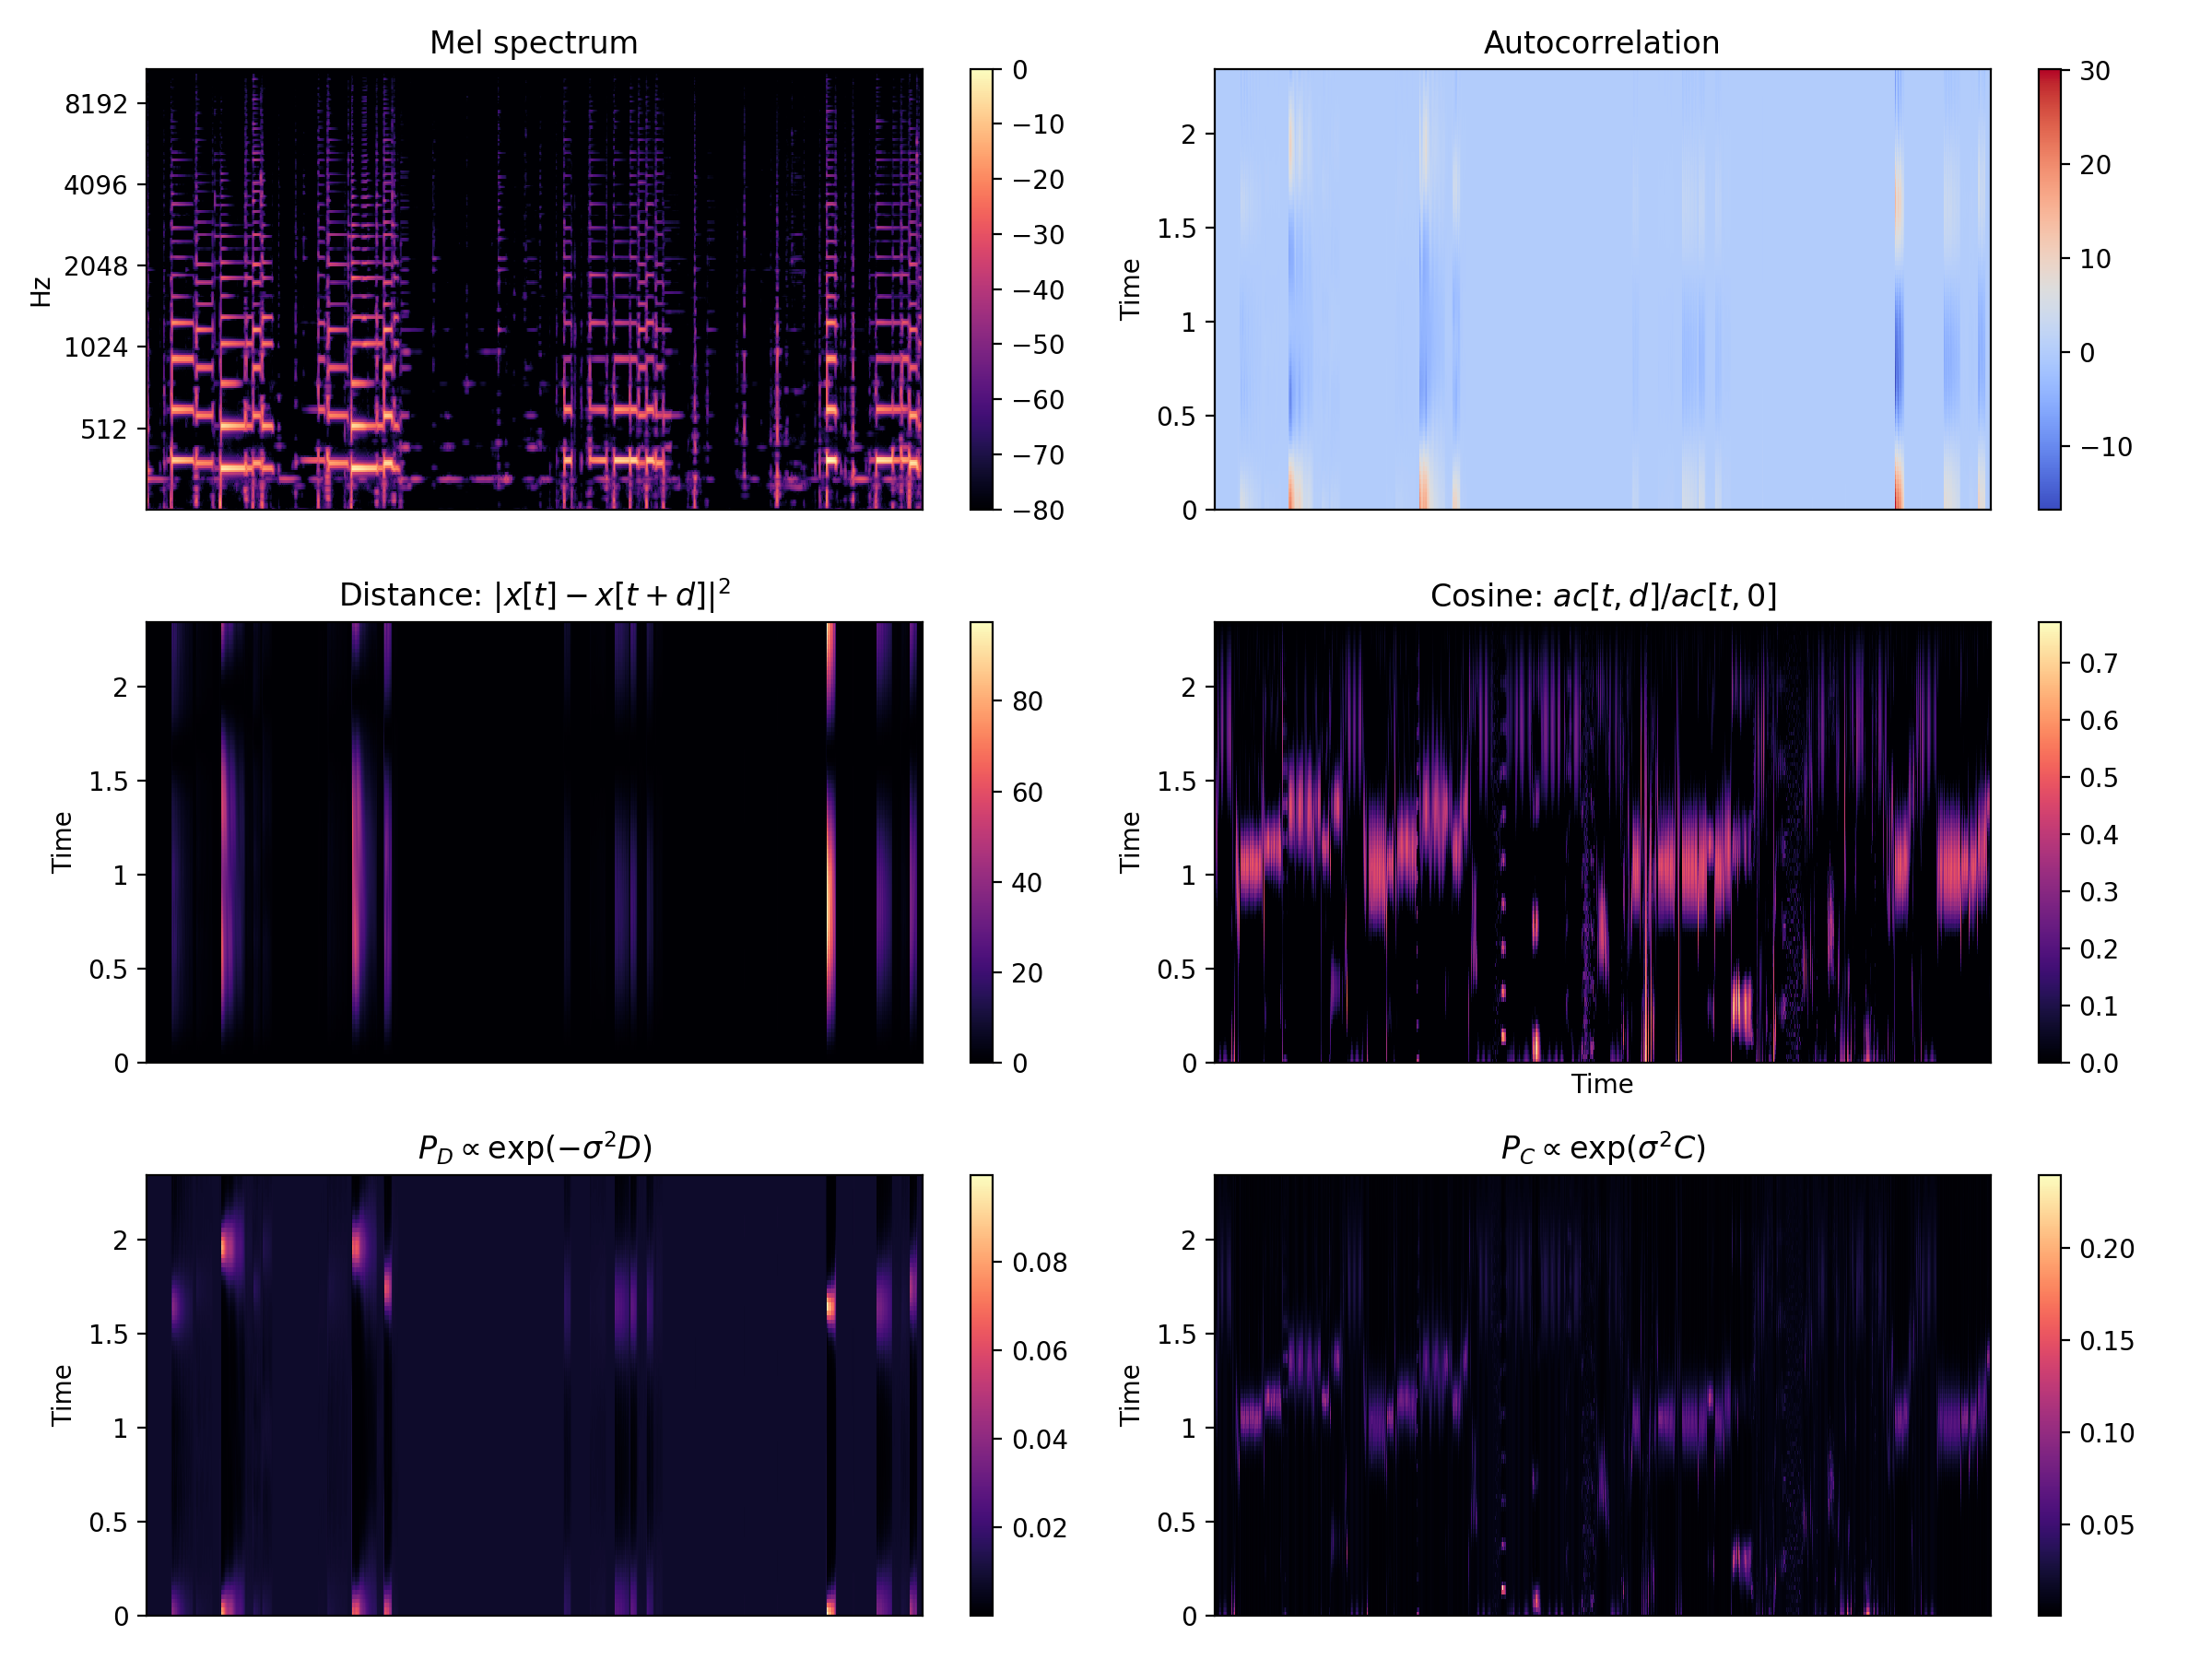

In [64]:
plt.figure(figsize=(12, 9))
plt.subplot(3,2,1)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel')
plt.colorbar()
plt.title('Mel spectrum')

ax = plt.subplot(3,2,2)
librosa.display.specshow(A, x_axis='time', y_axis='time')
plt.xlabel('')
plt.xticks([])
plt.title('Autocorrelation')
plt.colorbar()

plt.subplot(3,2,3, sharex=ax, sharey=ax)
librosa.display.specshow(D, x_axis='time', y_axis='time')
plt.title(r'Distance: $|x[t] - x[t+d]|^2$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()
plt.subplot(3,2,4, sharex=ax, sharey=ax)
librosa.display.specshow(C, x_axis='time', y_axis='time')
plt.title(r'Cosine: $ac[t, d] / ac[t,0]$')
plt.colorbar()

plt.subplot(3,2,5, sharex=ax, sharey=ax)
librosa.display.specshow(P, x_axis='time', y_axis='time')
plt.title(r'$P_D \propto \exp(-\sigma^2 D)$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()

plt.subplot(3,2,6, sharex=ax, sharey=ax)
librosa.display.specshow(P2, x_axis='time', y_axis='time')
plt.title(r'$P_C \propto \exp(\sigma^2 C)$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()
plt.tight_layout()

# TODO
- Add a separate P2 state for unvoiced bits
- Bake in silence state to transition matrix construction

In [150]:
P4.shape

(101, 948)

In [151]:
n_pitches = P4.shape[0]

In [152]:
#T = make_self_transition(n_pitches)
T = make_bump_transition(n_pitches, width=30)

In [153]:
seq, values, pointers = viterbi(P4.T, T)

In [154]:
f_detect = float(sr) / (seq + min_lag)
f_detect[seq == 0] *= -1

In [72]:
D_cliped = D[min_lag[0] : max_lag[0]]
D_min_idx = np.argmin(D_cliped, axis=0)
D_f_detect = float(sr) / (D_min_idx + min_lag)
D_f_detect[D_min_idx == 0] *= -1

<IPython.core.display.Javascript object>


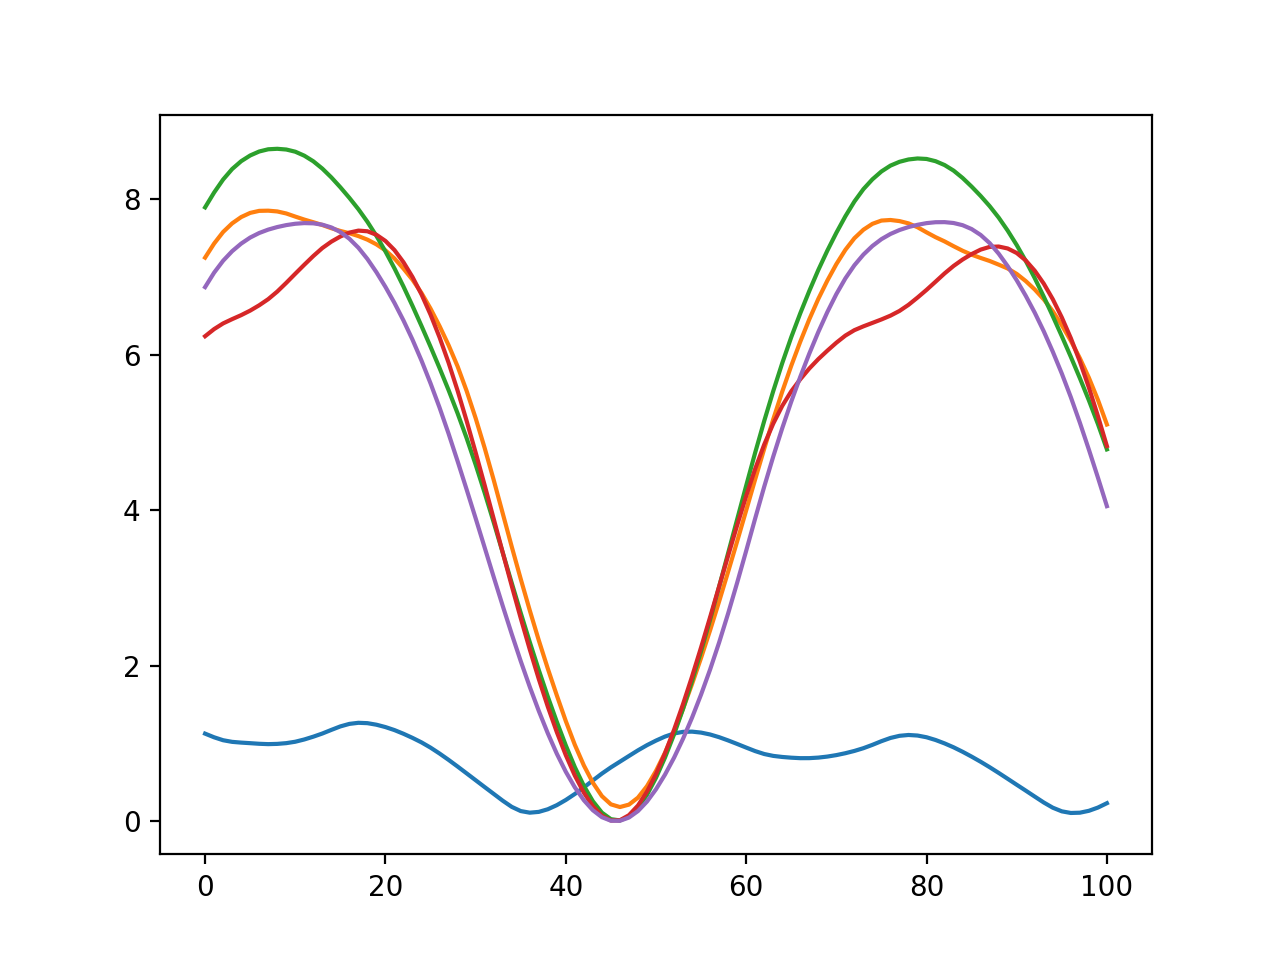

In [97]:
plt.figure()
for d in D_cliped.T[510:515]:
    
    plt.plot(d)
    plt.show()

<IPython.core.display.Javascript object>


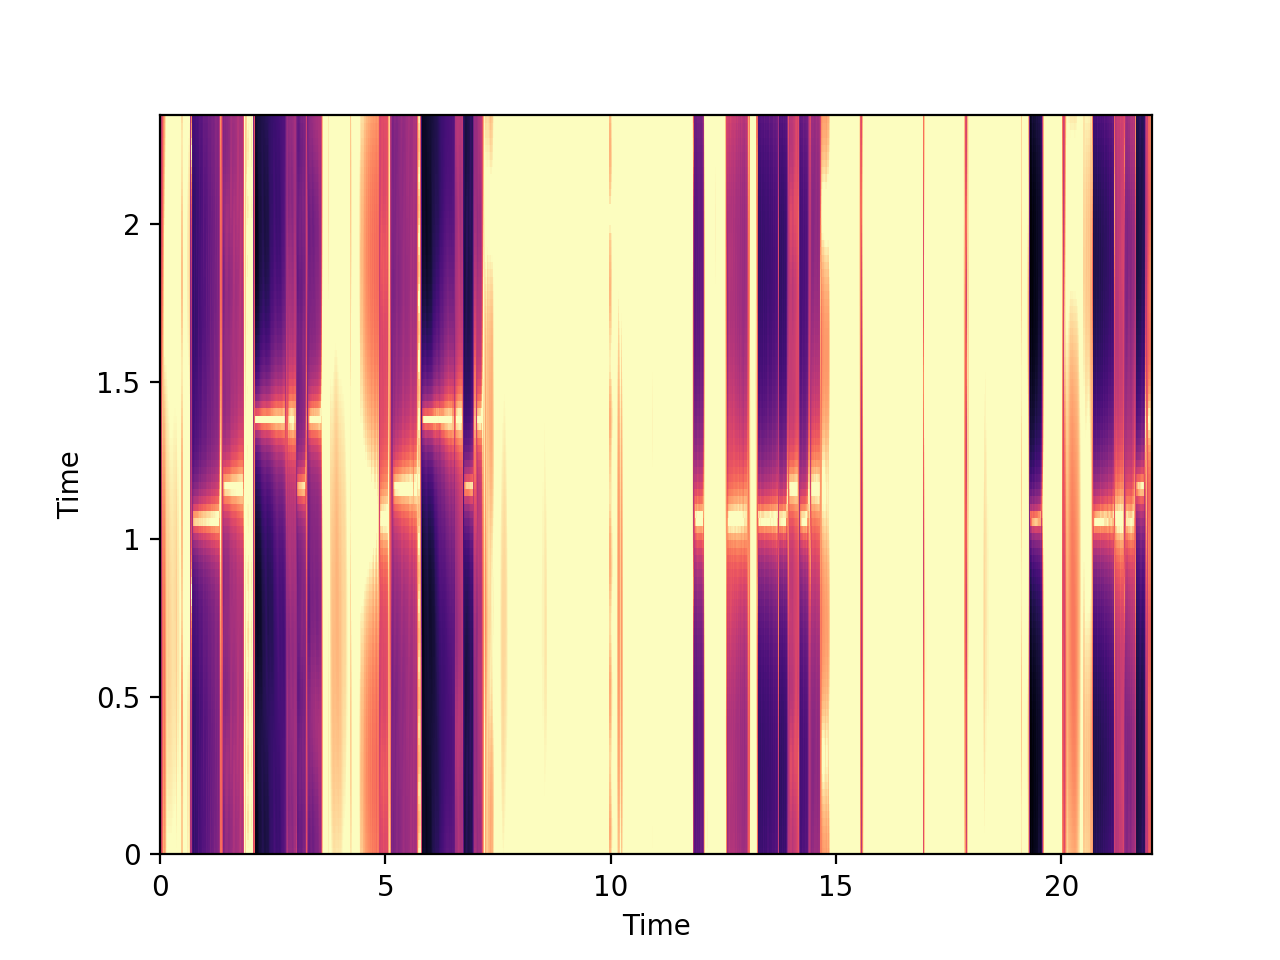

In [147]:
D_cliped = D[min_lag[0] : max_lag[0]]
P3 = -librosa.amplitude_to_db(D_cliped, ref=np.max)
librosa.display.specshow(P3, y_axis='time', x_axis='time', sr=sr)

<IPython.core.display.Javascript object>


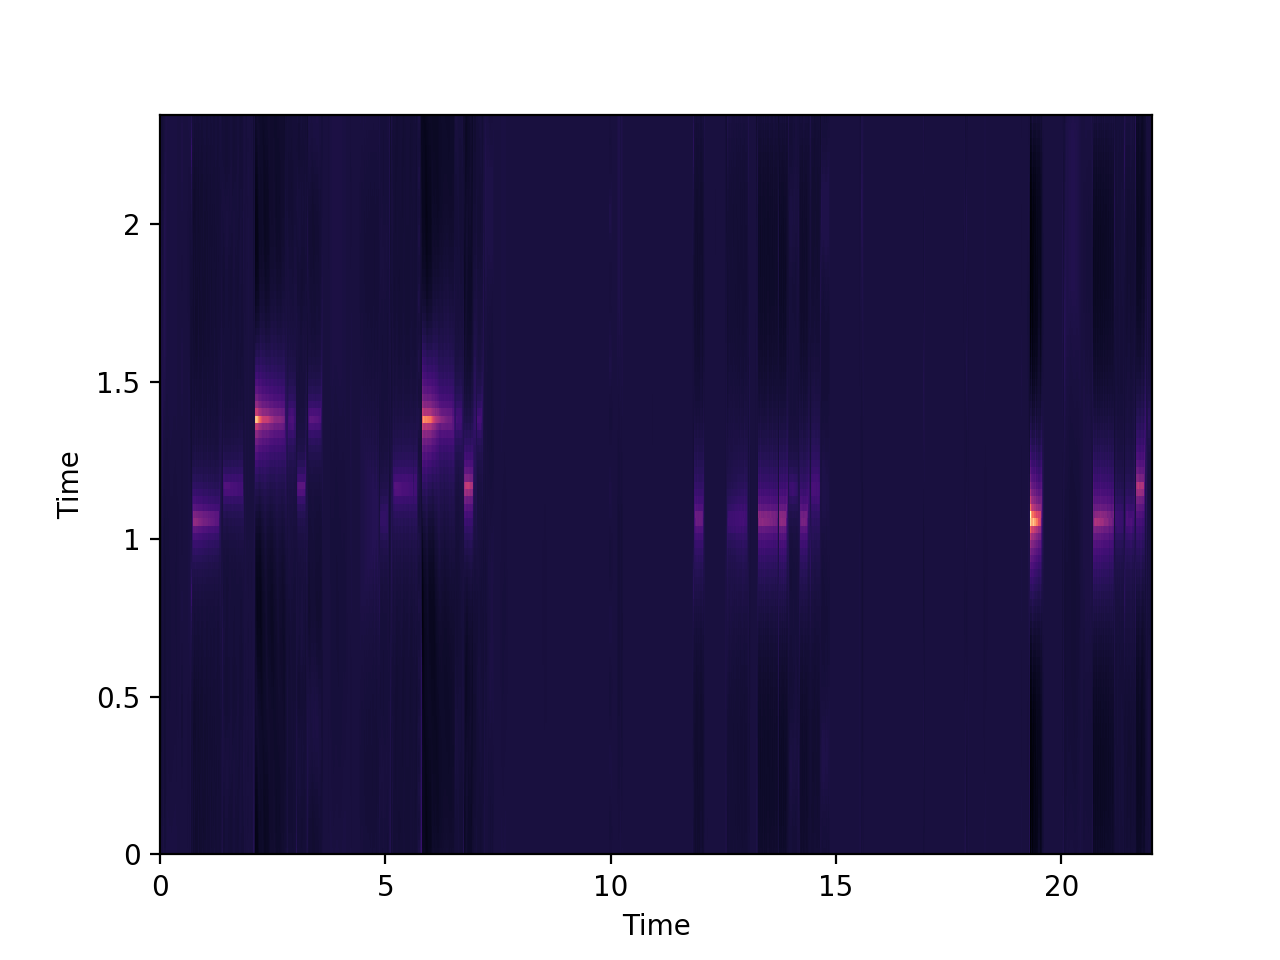

In [149]:
P4 = []
for row in P3.T:
    normalized_row = row / np.sum(row)
    P4.append(normalized_row)
P4 = np.array(P4).T
librosa.display.specshow(P4, y_axis='time', x_axis='time', sr=sr)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


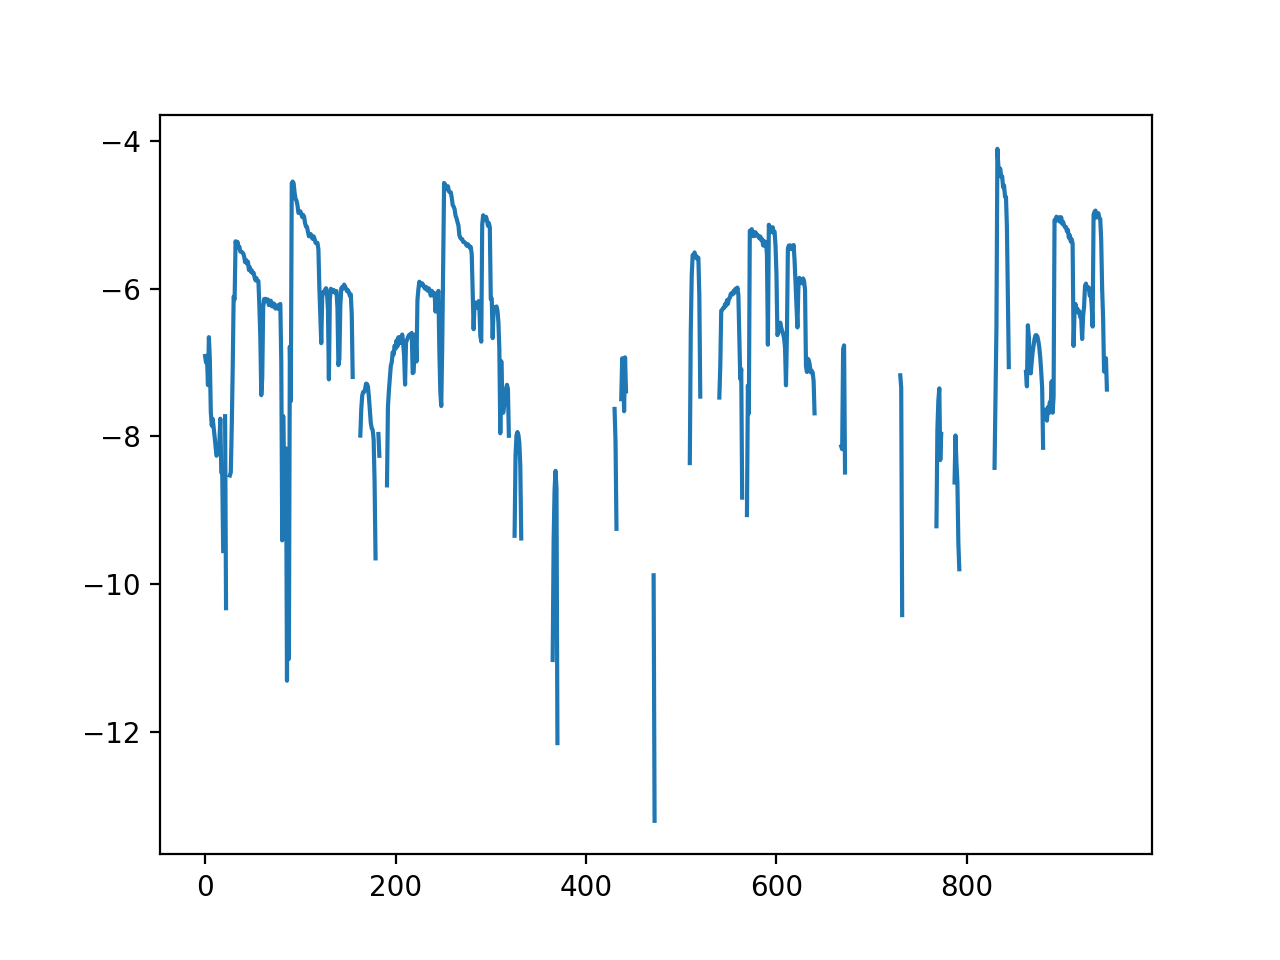

In [141]:
# P3_sum = np.sum(P3, axis=0)
# P3_std = np.std(P3, axis=0)
# logp_voicing = np.log(P3_std/P3_sum)
# plt.figure()
# plt.plot(logp_voicing)
# plt.show()

In [155]:
import mir_eval.display

In [156]:
times = librosa.frames_to_time(np.arange(len(f_detect)), sr=sr)

<IPython.core.display.Javascript object>


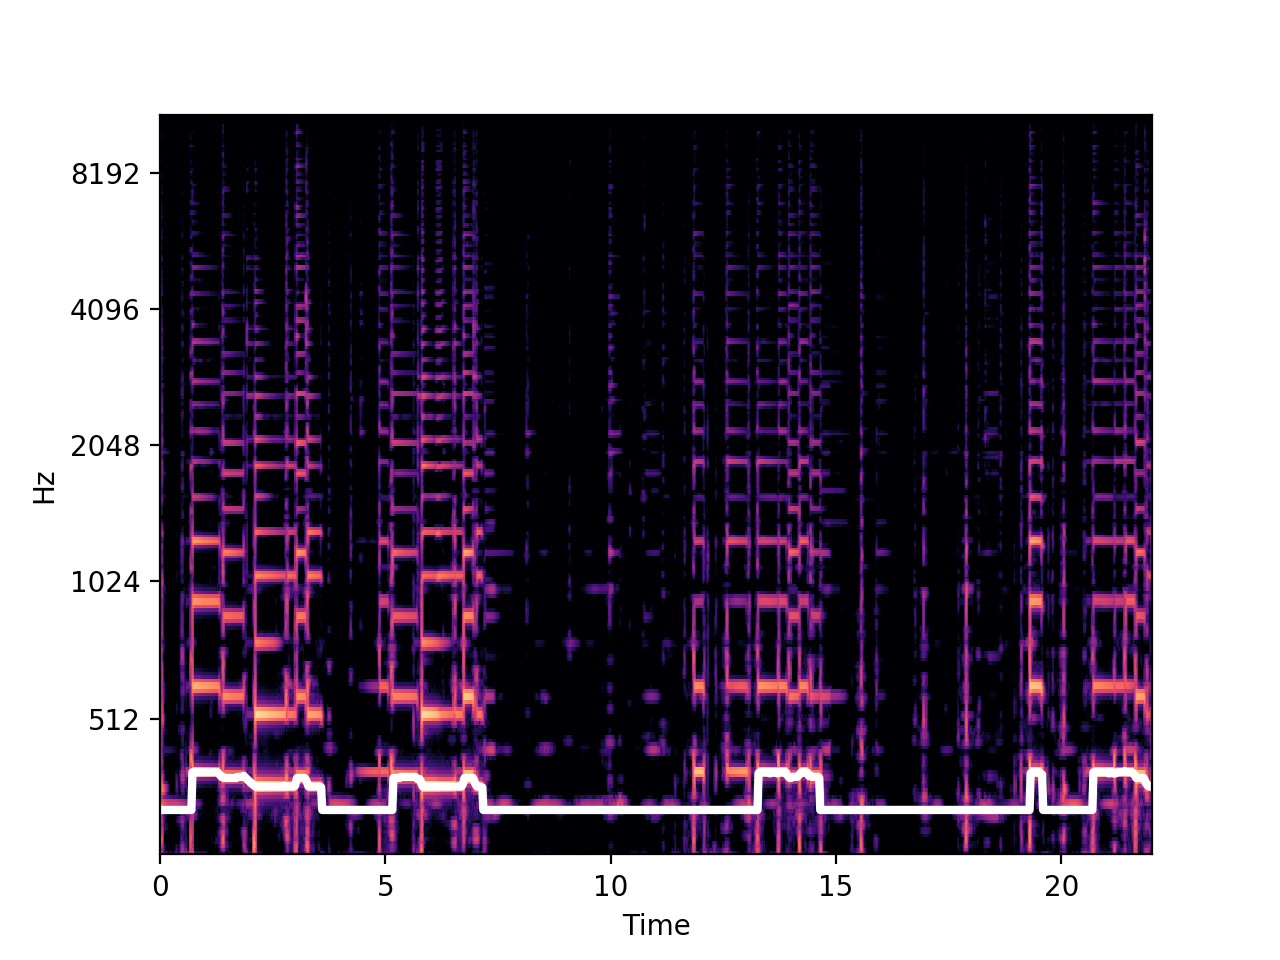

In [157]:
plt.figure()
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, x_axis='time')
mir_eval.display.pitch(times, f_detect, color='w', linewidth=3)

In [158]:
import mir_eval.sonify

In [159]:
son = mir_eval.sonify.pitch_contour(times, f_detect, fs=sr, length=len(y))

In [160]:
Audio(data=y+son, rate=sr)